Due Date: May 2nd (Ignore Canvas due date) 

In this homework we will work on minimizing functions using numerical minimizing algorithms. These algorithms can often have trouble converging due to various issues. Many of these algorithms depend on calculating the derivative of the function in some way. Numerical approximations of derivatives can be tricky to calculate, so it often helps to have an analytical form of the function derivative. We will work on a couple of examples of this in this homework and help the minimizer coverage by calculating the derivatives. Submit a Jupyter notebook with your work and answers for this assignment. 

## 1. Minimizing a 2D function

In this section we will implement and test the function 
\[
f(x,y) = x^2 + y^2
\]
and its gradient, and use `scipy.optimize.minimize` with and without the supplied Jacobian.

---

### 1.a) Define the function for `scipy.optimize.minimize`


In [93]:
import numpy as np

def f_2d(vars):
    """
    Compute f(x,y) = x^2 + y^2

    Parameters
    ----------
    vars : array-like, shape (2,)
        [x, y]

    Returns
    -------
    float
        x^2 + y^2
    """
    x, y = vars
    return x**2 + y**2


### 1.b) Define the gradient function

In [94]:
def grad_f_2d(vars):
    """
    Compute gradient of f(x,y) = x^2 + y^2

    Parameters
    ----------
    vars : array-like, shape (2,)
        [x, y]

    Returns
    -------
    ndarray, shape (2,)
        [$\partial f/\partial x$, $\partial f/\partial y$] = [2x, 2y]
    """
    x, y = vars
    return np.array([2*x, 2*y])


### 1.c) Numerical derivative vs analytical derivative

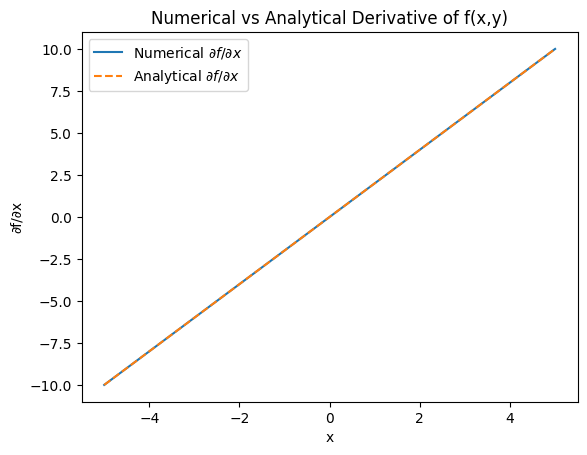

In [95]:
import matplotlib.pyplot as plt

# x array from -5 to 5, y=0
x_vals = np.linspace(-5, 5, 500)
y0 = 0.0

# numerical derivative ∂f/∂x ≈ Δf/Δx
dx = 1e-5
num_deriv = ( (x_vals + dx)**2 + y0**2 - (x_vals**2 + y0**2) ) / dx

# analytical derivative from grad_f_2d
analytical = np.array([grad_f_2d([x, y0])[0] for x in x_vals])

plt.figure()
plt.plot(x_vals, num_deriv, label='Numerical $\partial f/\partial x$')
plt.plot(x_vals, analytical, '--', label='Analytical $\partial f/\partial x$')
plt.xlabel('x')
plt.ylabel('∂f/∂x')
plt.legend()
plt.title('Numerical vs Analytical Derivative of f(x,y)')
plt.show()


### 1.d) Minimize without supplying the gradient

In [96]:
from scipy.optimize import minimize

initial_guess = [1.0, 1.0]
res_no_jac = minimize(f_2d, initial_guess)
print("Without jac:", res_no_jac.x, "Function calls:", res_no_jac.nfev)


Without jac: [-1.07505143e-08 -1.07505143e-08] Function calls: 9


### 1.e) Minimize with the analytical gradient

In [97]:
res_with_jac = minimize(f_2d, initial_guess, jac=grad_f_2d)
print("With jac:", res_with_jac.x, "Function calls:", res_with_jac.nfev, "Gradient calls:", res_with_jac.njev)


With jac: [0. 0.] Function calls: 3 Gradient calls: 3


**Providing the Jacobian resulted in a more precice result for our minimum in less function calls.**

___
## 2. Minimizing a model fit to data

We will read in the data, compute rates and errors, plot, fit a power-law decay, and find the best-fit parameters.
___

### 2.a) Read in Decaying_LC.fits

In [98]:
from astropy.io import fits

# Load the FITS table
with fits.open("Decaying_LC.fits") as f:
    f.info()
    data = f[1].data

#data.columns.names #Checking if the HDU has the proper data

counts = data['COUNTS']      # observed counts
exposure = data['EXPOSURE']  # exposure time [s]
time_mid = data['TIME']      # time since reference [s]


Filename: Decaying_LC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     17   9R x 3C   [D, K, D]   


### 2.b) Compute count rates and $1\sigma$ errors

In [99]:
# Rate = counts / exposure
rates = counts / exposure
# Poisson error on counts is sqrt(counts)
rate_err = np.sqrt(counts) / exposure


### 2.c) Plot observed rates vs time on log–log axes

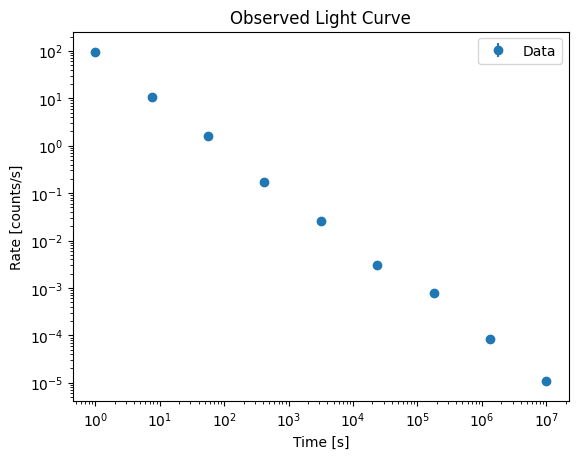

In [100]:
plt.figure()
plt.errorbar(time_mid, rates, yerr=rate_err, fmt='o', label='Data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Rate [counts/s]')
plt.legend()
plt.title('Observed Light Curve')
plt.show()


### 2.d) Define the power-law model

$$ R(A,α,t)=A(\frac{t}{​t_0}​)^α,t_0​=10^5 s.$$

In [101]:
t0 = 1e5

def powerlaw_model(params, t):
    """
    Power-law model R(A, alpha, t) = A * (t/t0)^alpha

    Parameters
    ----------
    params : array-like, shape (2,)
        [A, alpha]
    t : array-like
        Times [s]

    Returns
    -------
    ndarray
        Model rates at times t
    """
    A, alpha = params
    return A * (t / t0)**alpha


### 2.e) Define $\chi^2$ function

In [102]:
def chi2(params, t, rates, rate_err):
    """
    Compute chi-squared between data and model.

    Parameters
    ----------
    params : array-like, shape (2,)
        [A, alpha]
    t : array-like
        Times [s]
    rates : array-like
        Observed rates
    rate_err : array-like
        Errors on observed rates

    Returns
    -------
    float
        chi-squared
    """
    model = powerlaw_model(params, t)
    return np.sum( ((rates - model) / rate_err)**2 )


### 2.f) Fit using scipy.optimize.minimize

In [103]:
initial = [1e-2, -2.0]  # A=1e-2 counts/s, alpha=-2
res_fit = minimize(chi2, initial, args=(time_mid, rates, rate_err))
best_A, best_alpha = res_fit.x
print("Best-fit (no jac): A =", best_A, ", alpha =", best_alpha)


Best-fit (no jac): A = 3.5480758780402216e-09 , alpha = -1.998732282298946


___
## 3. Supplying analytic derivatives (Jacobian)

We now derive and implement the partial derivatives of $\chi^2$ with respect to A and $\alpha$.
___

### 3.a) Analytic form of $\partial R / \partial A$ and $ \partial R / \partial \alpha.$

In LaTeX:  
$$\frac{\partial R}{\partial A} = \left( \frac{t}{t_0} \right)^\alpha,\quad
\frac{\partial R}{\partial \alpha} = A \left( \frac{t}{t_0} \right)^\alpha \ln\left( \frac{t}{t_0} \right)$$

The derivative of  
$$\chi^2 = \sum_i \left( \frac{r_i - R(A, \alpha, t_i)}{\sigma_i} \right)^2$$

with respect to a parameter $x \in \{A, \alpha\}$ is:  
$$\frac{\partial \chi^2}{\partial x} = \sum_i 2 \frac{r_i - R}{\sigma_i^2} \left( -\frac{\partial R}{\partial x} \right) = -2 \sum_i \frac{r_i - R}{\sigma_i^2} \frac{\partial R}{\partial x}$$


### 3.b) Python function returning $\partial \chi^2 / \partial A$ and $ \partial \chi^2 / \partial \alpha.$

In [104]:
def grad_chi2(params, t, rates, rate_err):
    """
    Compute the gradient of chi2 w.r.t. A and alpha.

    Returns d(chi2)/dA and d(chi2)/dalpha.
    """
    A, alpha = params
    model = powerlaw_model(params, t)
    # partials of R
    dR_dA = (t / t0)**alpha
    dR_dalpha = A * (t / t0)**alpha * np.log(t / t0)
    
    residual = rates - model
    inv_var = 1.0 / rate_err**2
    
    # derivatives of chi2
    dchi2_dA = -2.0 * np.sum(residual * inv_var * dR_dA)
    dchi2_dalpha = -2.0 * np.sum(residual * inv_var * dR_dalpha)
    
    return np.array([dchi2_dA, dchi2_dalpha])


### 3.c) Test analytic derivative vs numerical

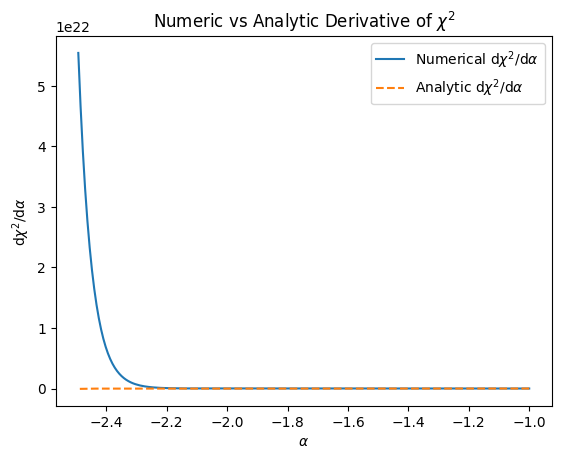

In [109]:
# Fix A = 1e-2, vary alpha from -1 to -2.5
alphas = np.linspace(-1, -2.5, 200)
# numerical derivative of chi2 wrt alpha
dalpha = 1e-5
chi2_vals = [chi2([1e-2, a], time_mid, rates, rate_err) for a in alphas]
num_dchi2 = np.diff(chi2_vals) / dalpha
# analytic derivative
ana_dchi2 = [grad_chi2([1e-2, a], time_mid, rates, rate_err)[1] for a in alphas[:-1]]

plt.figure()
plt.plot(alphas[:-1], num_dchi2, label='Numerical d$\chi^2 / $d$\\alpha$')
plt.plot(alphas[:-1], ana_dchi2, '--', label='Analytic d$\chi^2 / $d$\\alpha$')
plt.xlabel('$\\alpha$')
plt.ylabel('d$\chi^2 / $d$\\alpha$')
plt.legend()
plt.title('Numeric vs Analytic Derivative of $\chi^2$')
plt.show()


### 3.d) Minimize $\chi^2$ supplying the Jacobian

In [106]:
res_jac = minimize(chi2, initial, args=(time_mid, rates, rate_err),
                   jac=grad_chi2, method='BFGS')
best_A_jac, best_alpha_jac = res_jac.x
print("Best-fit (with jac): A =", best_A_jac, ", alpha =", best_alpha_jac)
print("Converged:", res_jac.success, "Function calls:", res_jac.nfev)


Best-fit (with jac): A = 0.0009816997051284378 , alpha = -0.9773953023996703
Converged: True Function calls: 115


###  3.e) Plot best-fit model over data

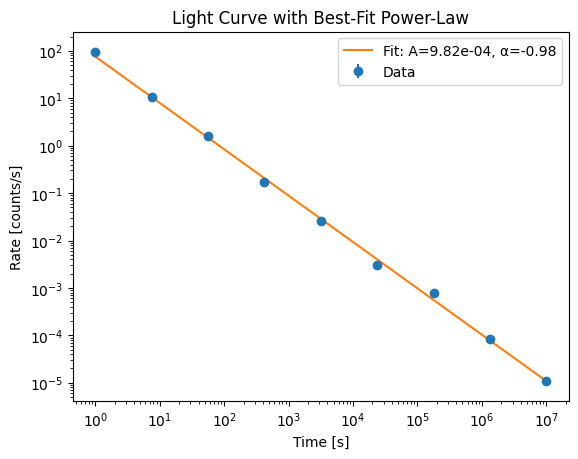

In [107]:
plt.figure()
plt.errorbar(time_mid, rates, yerr=rate_err, fmt='o', label='Data')
t_plot = np.logspace(np.log10(time_mid.min()), np.log10(time_mid.max()), 300)
model_plot = powerlaw_model([best_A_jac, best_alpha_jac], t_plot)
plt.plot(t_plot, model_plot, '-', label=f'Fit: A={best_A_jac:.2e}, α={best_alpha_jac:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Rate [counts/s]')
plt.legend()
plt.title('Light Curve with Best-Fit Power-Law')
plt.show()
